<a href="https://colab.research.google.com/github/Sardaan/puzzle/blob/main/puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geojson

In [2]:
import os
from os.path import join
import numpy as np
import cv2
import matplotlib.pyplot as plt
from side_extractor import process_piece, plot_side_images
from functools import partial
import traceback

import vkr

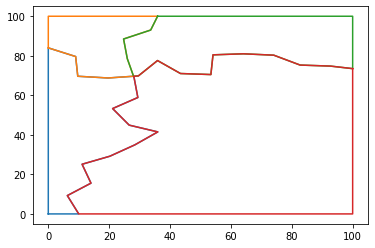

In [8]:
import matplotlib.pyplot as plt
from math import sin, cos, radians as rad
import random
from shapely.geometry import Polygon, LineString, mapping, MultiPolygon
from shapely.ops import polygonize
from geojson import Feature, FeatureCollection, dump, load

from PIL import Image
import cv2
import numpy as np



alpha = 0.5 # that's your transparency factor

# f-количество трещин
def makeCrack(f, filename):
  height = 100
  length = 100
  step = 10

  # схрон полигонов
  pole = [Polygon([(0, 0), (0, height), (length, height), (length, 0)])]

  # количество трещин
  for i in range(f):
    if i % 2:
        x, y = 0, random.randint(0, height)
        fi = 0
    else:
        x, y = random.randint(0, length), 0
        fi = 90

    b = [(x, y)]
    while 0 <= x < length and 0 <= y < height:
        a = rad(random.randint(-90 + fi, 90 + fi))
        x += step * cos(a)
        y += step * sin(a)

        b += [(x, y)]

    pole_2 = []
    for k in pole:
        pole_2 += [poly for poly in polygonize(k.boundary.union(LineString(b))) if
                    poly.representative_point().within(k)]
    pole = pole_2

  # нарисовать их

  pieceNumber = 1
  for i in pole:
    plt.plot(*i.exterior.xy)  
    pieceNumber += 1
  plt.savefig(filename, dpi=300)
  plt.show()
 

  pole = MultiPolygon(pole)
  with open('fragments.geojson', 'w') as f:
    dump(mapping(pole), f)



makeCrack(2, "/content/drive/MyDrive/crackImg/image2.png")

In [9]:
with open('fragments.geojson', 'r') as f:
  pole = load(f)

In [10]:
pole.keys()

dict_keys(['type', 'coordinates'])

In [11]:
pole['coordinates'] = np.array(pole['coordinates'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


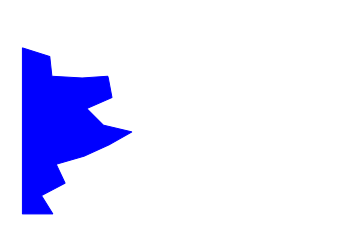

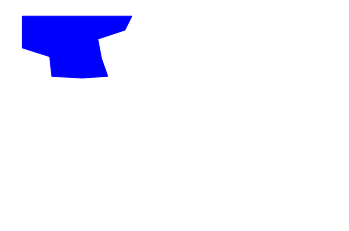

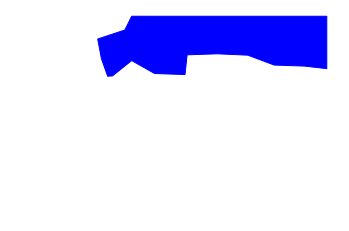

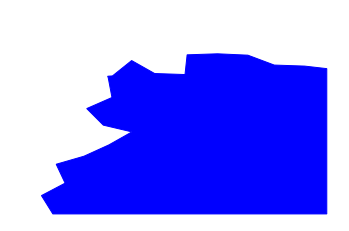

In [12]:
if not os.path.isdir('puzzle_parts'):
  os.mkdir('puzzle_parts')

for i, line_pol in enumerate(pole['coordinates']):
  plt.fill(np.array(line_pol[0])[:, 0], np.array(line_pol[0])[:, 1], fill=True, color='blue')
  plt.axis('off')
  plt.xlim(-5, 105)
  plt.ylim(-5, 105)
  plt.savefig(f'puzzle_parts/pol{i}.png', bbox_inches='tight', pad_inches=0)
  plt.show()

In [13]:
PUZZLE_PARTS_DIR = './puzzle_parts'
filenames = os.listdir(PUZZLE_PARTS_DIR)
filenames.sort()

In [14]:
def plot_grid(size, out_dict, *image_keys):
    h, w = size
    for idx, img_key in enumerate(image_keys, start=1):
        plt.subplot(h * 100 + w * 10 + idx)
        if img_key[0] == '_':
            plt.imshow(out_dict[img_key[1:]], cmap='gray')
        else:
            plt.imshow(out_dict[img_key])


In [15]:
label_tuples = [('A', 74), ('B', 43), ('C', 19), ('D', 72), ('E', 11)]

def create_label(label_tuple):
    letter, max_num = label_tuple
    for i in range(1, max_num + 1):
        label = letter + str(i) if i >= 10 else letter + '0' + str(i)
        yield label
        
labels = []
for label_tuple in label_tuples:
    for label in create_label(label_tuple):
        labels.append(label)

(217, 334, 3)


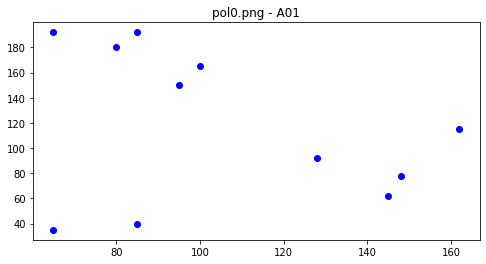

(217, 334, 3)


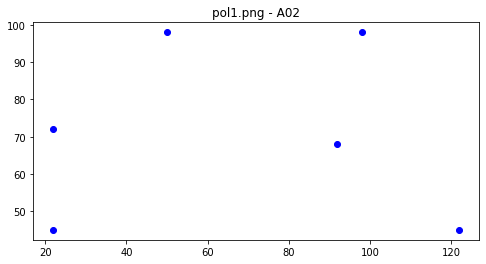

(217, 334, 3)


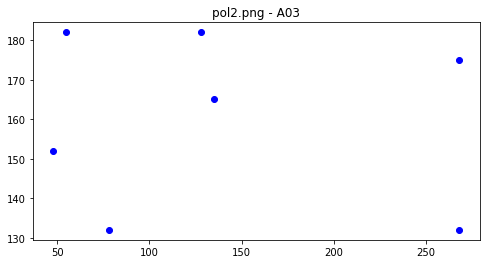

(217, 334, 3)


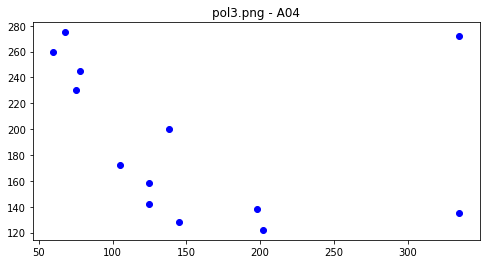

In [16]:
postprocess = partial(cv2.blur, ksize=(3, 3))
results = []
error_labels = []

if not os.path.isdir('puzzle_points'):
  os.mkdir('puzzle_points')

for filename, label in zip(filenames, labels):
    img = cv2.imread(join(PUZZLE_PARTS_DIR, filename))
    print(img.shape)

    out_dict = process_piece(img, after_segmentation_func=postprocess, scale_factor=0.4, 
                             harris_block_size=5, harris_ksize=5,
                             corner_score_threshold=0.2, corner_minmax_threshold=100)
    
    plt.figure(figsize=(8, 4))
    plt.title("{0} - {1}".format(filename, label))
    # plt.imshow(img, cmap='gray')
    # plt.scatter(out_dict['xy'][:, 0], out_dict['xy'][:, 1], color='blue')
    plt.scatter(out_dict['xy'][:, 0], out_dict['xy'][:, 1], color='blue')
    plt.savefig(f'puzzle_points/pol_{filename}', bbox_inches='tight', pad_inches=0)

    #plt.colorbar()
    plt.show()

    results.append(out_dict)
    
    # if 'error' in out_dict:
    #     print (label, ':', out_dict['error'])
    #     error_labels.append(label)
    #     traceback.print_exc()
    #     continue
        
    # else:
        
    #     plt.figure(figsize=(6, 6))
    #     # plt.title("{0} - {1}".format(filename, label))
    #     plt.imshow(out_dict['class_image'])
    #     #plot_grid((3, 3), out_dict, '_segmented', '_extracted', '_edges', 'class_image')
    #     # plt.show()

    #     # plot_side_images(out_dict['side_images'], out_dict['inout'])

    #     results.append({'side_images': out_dict['side_images'], 'inout': out_dict['inout']})
        

Нахождение по геометрическим особенностям

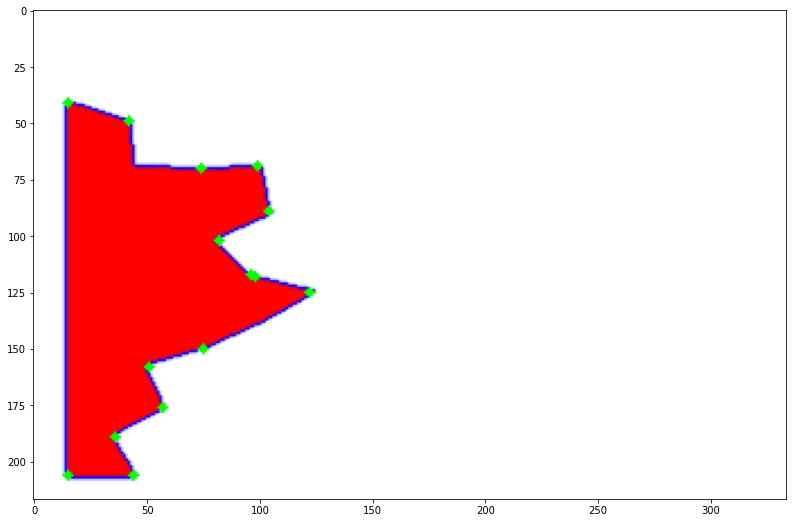

In [17]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point



def findFeaturePoints(img):

  fast = cv.FastFeatureDetector_create()
  kp = fast.detect(img, None)

  hsv_min = np.array((1, 1, 1), np.uint8)
  hsv_max = np.array((255, 220, 220), np.uint8)

  thresh = cv.inRange( img, hsv_min, hsv_max ) 
  contours, hierarchy = cv.findContours( thresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  return [kp, contours, hierarchy]


img2 = cv.imread('/content/puzzle_parts/pol0.png') 
kp2, contours2, hierarchy2 = findFeaturePoints(img2)

# drawContours( кадр, контуры, индекс, цвет[, толщина[, тип_линии[, иерархия[, макс_слой[, сдвиг]]]]])
cv.drawContours(img2, contours2, -1, (0,0,255), 1, cv.LINE_AA, hierarchy2, 1)

radius = 2
  # print(contours)
for keypoint in kp2:
  x,y = keypoint.pt
  coord = int(x),int(y)
  img = cv2.circle(img2, coord, radius, (0, 255, 0), -1)


plt.figure(figsize=(16, 9))
plt.imshow(img2)
plt.show()


In [313]:
# print(contours)
# for cnt in contours:
#   print(cnt)

Находим среди точек контура саму ближайшую к фиче поинту где R> заданного радиуса

In [18]:
import math
def dist(dot1, dot2):
  x1 = dot1[0]
  x2 = dot2[0]
  y1 = dot1[1]
  y2 = dot2[1]

  calc = math.sqrt((x2-x1)**2 + (y2-y1)**2)
  return calc
 
def angle3pt(a, b, c):
    """Counterclockwise angle in degrees by turning from a to c around b
        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    
    return ang + 360 if ang < 0 else ang

# [32, 67] [33.0, 66.0] [28, 68] 23.198590513648185
print(angle3pt((32, 67), (33, 66), (28, 68)))

23.198590513648185


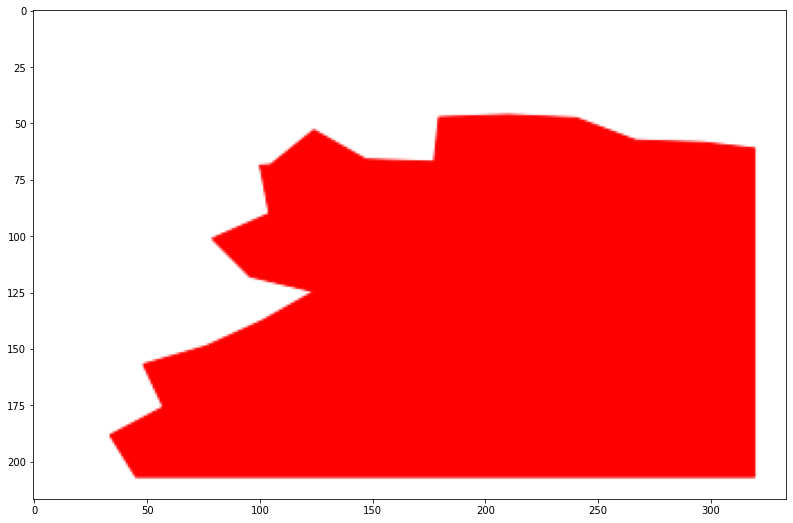

In [166]:
def detectAngle(kp, contours):
  contoursDots = []
  for i in range(len(contours)):
    for j in range(len(contours[i])):
      point = [contours[i][j][0][0],contours[i][j][0][1]]
      contoursDots.append(point)
  # print("len",len(contoursDots))
  angles = []
  for keypoint in kp:

    R = 10
    r_min = 10
    index_min = 0
    
    b = [int(keypoint.pt[0]), int(keypoint.pt[1])]

    for i in range(len(contoursDots)):
      if dist(b, contoursDots[i]) < r_min:
        r_min = dist(b, contoursDots[i])
        index_min = i
          
    j = index_min
    # b = contoursDots[j]
    a = contoursDots[j]
    while dist(a,b) < R:
      # print("index ",j)
      # print("dist ",dist(a,b))
      a = contoursDots[j]
      # print("left ",contours[i][j][0])
      if (j < 1):
        j = len(contoursDots)-1
      else:
        j = j - 1
      
    
    j = index_min
    c = contoursDots[j]
    while dist(c, b) < R:
      # print("index ",j)
      # print("dist ",dist(c,b))
      c = contoursDots[j]
      # print("right ",contours[i][j][0])
      if (j > len(contoursDots)-2):
        j = 0
      else:
        j = j + 1

    angle = int(angle3pt(a, b, c) )
    angleData = [b, angle]
    angles.append(angleData) 
    # print(a,b,c, angle)

    # cv2.circle(img2, (int(keypoint.pt[0]), int(keypoint.pt[1])), 1, (0, 255, 0), -1)
    # cv2.circle(img, (a[0],a[1]), 1, (0, 255, 0), -1)
    # cv2.circle(img, (int(b[0]),int(b[1])), 1, (0, 0, 255), -1)
    # cv2.circle(img, (c[0],c[1]), 1, (0, 255, 255), -1)
 
  return(angles)

img2 = cv.imread('/content/puzzle_parts/pol3.png') 
kp2, contours2, hierarchy2 = findFeaturePoints(img2)
angles1 = detectAngle(kp2, contours2)

plt.figure(figsize=(16, 9))
plt.imshow(img2)
plt.show()

In [167]:
# Матрица переноса
# Матрица поворота 
# Потом какие фича поинты совпали 
# Рансак алгоритм для переноса плоскости / нет 



# b = np.where(img[:,:] != [0, 0, 255], [0, 0, 255], [0, 0, 0])

# plt.savefig(f'puzzle_parts/pol25.png', bbox_inches='tight', pad_inches=0)
# plt.imshow(b)
# plt.show()

def translateImg(img, x, y):
  rows, cols, dim = img.shape
  # матрица преобразования для перевода
  M = np.float32([ [1, 0, x],
                  [0, 1, y],
                  [0, 0, 1] ])
  translated_img = cv2.warpPerspective(img, M, (cols, rows))
  return translated_img

def translateCountour(contours, x, y):
  for i in range(len(contours)):
      for j in range(len(contours[i])):
        
        contours[i][j][0][0] = contours[i][j][0][0] + x
        contours[i][j][0][1] = contours[i][j][0][1] + y
        
  return contours

def translateDots(fp, dx, dy):
  for dot in fp:

    dot[0][0] = dot[0][0] + dx
    dot[0][1] = dot[0][1] + dy
          
  return fp


In [168]:
def rotate(img, angle):
  (h, w) = img.shape[:2]
  center = (w / 2, h / 2)

  # повернем изображение на 180 градусов
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(img, M, (w, h))
  return rotated

def rotateCountour(contours, angle, rotationDot):
  for i in range(len(contours)):
      for j in range(len(contours[i])):
        ox = rotationDot[0]
        oy = rotationDot[1]
        px, py = contours[i][j][0][0], contours[i][j][0][1]

        contours[i][j][0][0] = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        contours[i][j][0][1] = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        
  return contours    

def rotateDots(fp, angle, rotationDot):
  
  for dot in fp:
    ox = rotationDot[0]
    oy = rotationDot[1]
    px, py = dot[0][0], dot[0][1]

    dot[0][0] = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    dot[0][1] = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

  return fp   



In [169]:
def matchAngles(angles1, angles2):
  accuracy = 0.05
  match = []
  for angle1 in angles1:
    for angle2 in angles2:
      angle = angle1[1] + angle2[1]
      if (angle == 0):
        continue
      if 360/(angle) > (1 - accuracy) and 360/(angle) < (1 + accuracy):
        anglesMatch = [angle1, angle2]
        match.append(anglesMatch)
  
  return(match)


In [170]:
img0 = cv.imread('/content/puzzle_parts/pol0.png') 
img1 = cv.imread('/content/puzzle_parts/pol1.png') 
img2 = cv.imread('/content/puzzle_parts/pol2.png') 
img3 = cv.imread('/content/puzzle_parts/pol3.png')

images = [img0, img1, img2, img3]

def countMatches(images):
  angles = []
  for i in range(len(images)):
    kp, contours, hierarchy = findFeaturePoints(images[i])
    imgAngle  = detectAngle(kp, contours)
    angles.append(imgAngle)
  
  for i in range(len(images)):
    for j in range(len(images)):
      if (i!=j):
        partsMatch = matchAngles(angles[i], angles[j])
        result = i, j, len(partsMatch)
        print(result)

countMatches(images)

(0, 1, 20)
(0, 2, 25)
(0, 3, 36)
(1, 0, 20)
(1, 2, 14)
(1, 3, 25)
(2, 0, 25)
(2, 1, 14)
(2, 3, 23)
(3, 0, 36)
(3, 1, 25)
(3, 2, 23)


In [171]:
def doDotsMatch(contours1, contours2, n):
  cnt1_merged = mergeContours(contours1)
  cnt2_merged = mergeContours(contours2)
  
  accuracy = 1
  count = 0
  match = False
  for cnt1 in cnt1_merged:
    for cnt2 in cnt2_merged:
      coord1 = cnt1
      coord2 = cnt2
      d = dist(coord1, coord2)
      if (d < accuracy):
        count+=1
      if (count > n):
        match = True
        break
      
  return(match)

def mergeContours(contours):
  cnt = []
  for i in range(len(contours)):
    for j in range(len(contours[i])):
      cnt.append(contours[i][j][0])
  return cnt

img00 = cv.imread('/content/puzzle_parts/pol0.png') 
img11 = cv.imread('/content/puzzle_parts/pol1.png') 

kp1, contours1, hierarchy1 = findFeaturePoints(img00)
imgAngle1  = detectAngle(kp1, contours1)

kp2, contours2, hierarchy2 = findFeaturePoints(img11)
imgAngle2  = detectAngle(kp2, contours2)


print(doDotsMatch(contours1, contours2, 20))

True


angle  0


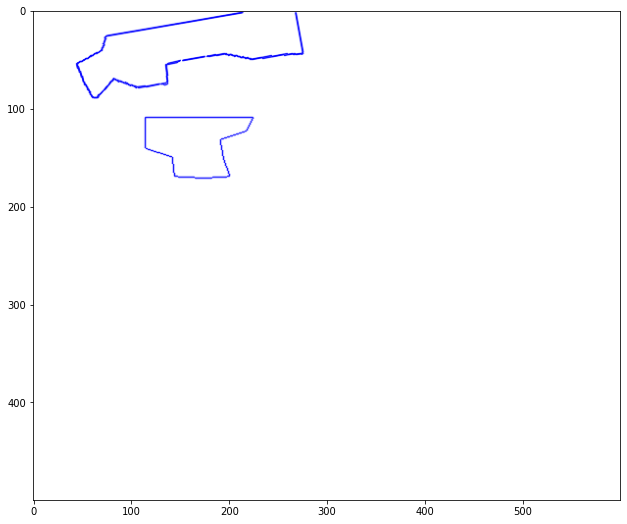

angle  5


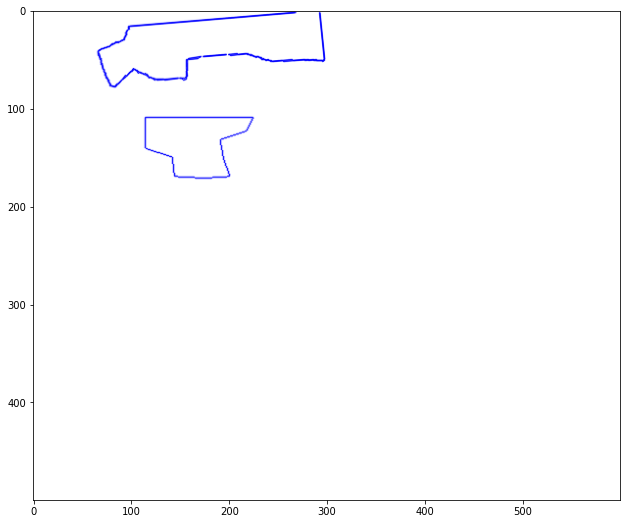

match found!


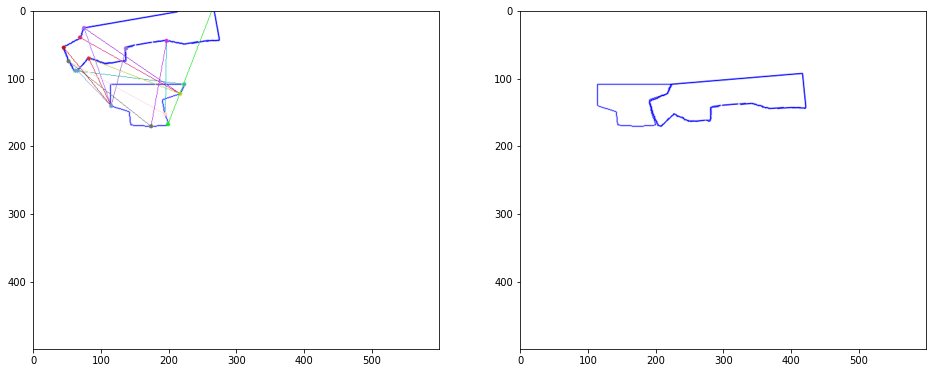

In [186]:

def matchParts(img1Name, img2Name):
  img1 = cv.imread(img1Name) 
  img2 = cv.imread(img2Name) 

  imagess = []
  height = 500
  width = 600
  canvas = np.zeros((height,width,3), np.uint8)
  canvas[::] = (255,255,255)

  kp1, contours1, hierarchy1 = findFeaturePoints(img1)
  imgAngle1  = detectAngle(kp1, contours1)

  kp2, contours2, hierarchy2 = findFeaturePoints(img2)
  imgAngle2  = detectAngle(kp2, contours2)
  
  # pre rotation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  dx0, dy0 = 100, 100
  contours1 = translateCountour(contours1, dx0, dy0)
  imgAngle1 = translateDots(imgAngle1, dx0, dy0)

  # dx, dy = 120, 150
  # contours2 = translateCountour(contours2, dx, dy)
  # imgAngle2 = translateDots(imgAngle2, dx, dy)
  angle = -10
  rotationDot = [200,300]
  contours2 = rotateCountour(contours2, math.radians(angle), rotationDot)
  imgAngle2 = rotateDots(imgAngle2, math.radians(angle), rotationDot)
  # pre rotation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  cv.drawContours( canvas, contours1, -1, (0,0,255), 1, cv.LINE_AA, hierarchy1, 1 )
  cv.drawContours( canvas, contours2, -1, (0,0,255), 1, cv.LINE_AA, hierarchy2, 1 )
  
  partsMatch = matchAngles(imgAngle1, imgAngle2)
  

  # print("draw found matches")
  for match in partsMatch:    
    r = random.randint(0,255)
    g = random.randint(0,255)
    b = random.randint(0,255)
    coord1 = int(match[0][0][0]), int(match[0][0][1])
    coord2 = int(match[1][0][0]), int(match[1][0][1])
  
    cv2.circle(canvas, coord1, 3, (r, g, b), -1)
    cv2.circle(canvas, coord2, 3, (r, g, b), -1)
    cv2.line(canvas, coord1, coord2,(r, g, b), 1) 
  
  
  # fig = plt.figure(figsize=(16, 9))
  # plt.imshow(canvas)
  # plt.show()
  imagess.append(canvas)
  # rows = 2
  # columns = 1
  # fig.add_subplot(rows, columns, 2)
  # plt.imshow(canvas)
  # plt.show()


  matchFound = False  
  countMatch = [] 
  rotAngle = 0
  while matchFound == False and rotAngle < 360:
    

    rotationDot = [200,300]
    
    kp2, contours2, hierarchy2 = findFeaturePoints(img2)
    imgAngle2  = detectAngle(kp2, contours2)
    ##### pre rotation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ang = -10
    rotationDot = [200,300]
    contours2 = rotateCountour(contours2, math.radians(ang), rotationDot)
    imgAngle2 = rotateDots(imgAngle2, math.radians(ang), rotationDot)
    ##### pre rotation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    

    print("angle ", rotAngle)
    contours2 = rotateCountour(contours2, math.radians(rotAngle), rotationDot)
    imgAngle2 = rotateDots(imgAngle2, math.radians(rotAngle), rotationDot)
    partsMatch = matchAngles(imgAngle1, imgAngle2)
    
    rotAngle = rotAngle + 5

    canvas2 = np.zeros((height,width,3), np.uint8)
    canvas2[::] = (255,255,255)

    cv.drawContours( canvas2, contours1, -1, (0,0,255), 1, cv.LINE_AA, hierarchy1, 1 )
    cv.drawContours( canvas2, contours2, -1, (0,0,255), 1, cv.LINE_AA, hierarchy2, 1 )
            
    fig = plt.figure(figsize=(16, 9))
    plt.imshow(canvas2)
    plt.show()


    for match in partsMatch:
      coord1 = int(match[0][0][0]), int(match[0][0][1])
      coord2 = int(match[1][0][0]), int(match[1][0][1])
      dx1 = coord1[0]-coord2[0]
      dy1 = coord1[1]-coord2[1]
      # print("coord ", coord1, coord2)
      
  
      contours2 = translateCountour(contours2, dx1, dy1)
      imgAngle2 = translateDots(imgAngle2, dx1, dy1)
      
      cnt = doDotsMatch(contours1, contours2, 30)
      
      countMatch.append(cnt)

      if (cnt == True):
        print("match found!")
        canvas2 = np.zeros((height,width,3), np.uint8)
        canvas2[::] = (255,255,255)

        cv.drawContours( canvas2, contours1, -1, (0,0,255), 1, cv.LINE_AA, hierarchy1, 1 )
        cv.drawContours( canvas2, contours2, -1, (0,0,255), 1, cv.LINE_AA, hierarchy2, 1 )

        imagess.append(canvas2) 
        # fig = plt.figure(figsize=(16, 9))
        # plt.imshow(canvas2)
        # plt.show()
        fig = plt.figure(figsize=(16, 9))
        columns = 2
        rows = 1
        for i in range(1, columns*rows +1):
          img = imagess[i-1]
          fig.add_subplot(rows, columns, i)
          # plt.axis('off')
          plt.imshow(img)
        plt.show()
        

        matchFound = True
        break
     
     

    


  return partsMatch
  


img00 = '/content/puzzle_parts/pol1.png'
img11 = '/content/puzzle_parts/pol2.png'
partsMatch = matchParts(img00,img11)


0 1
match found!


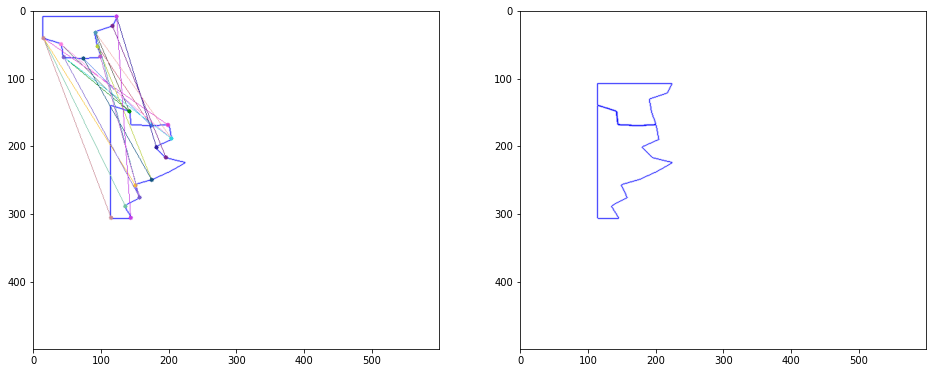

0 2
0 3
match found!


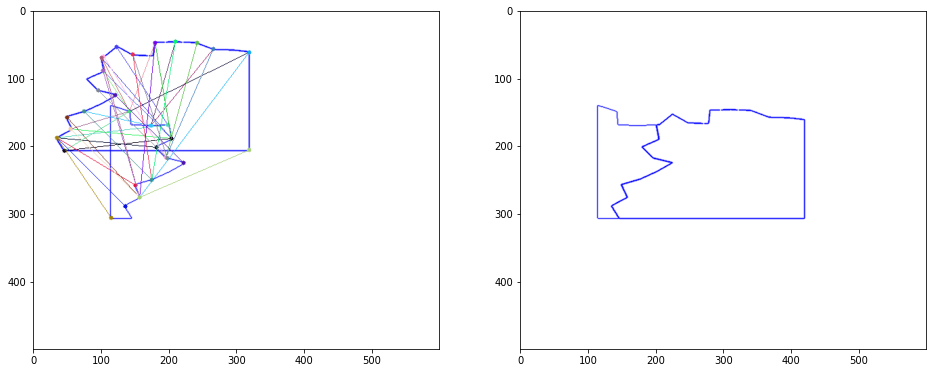

1 2
match found!


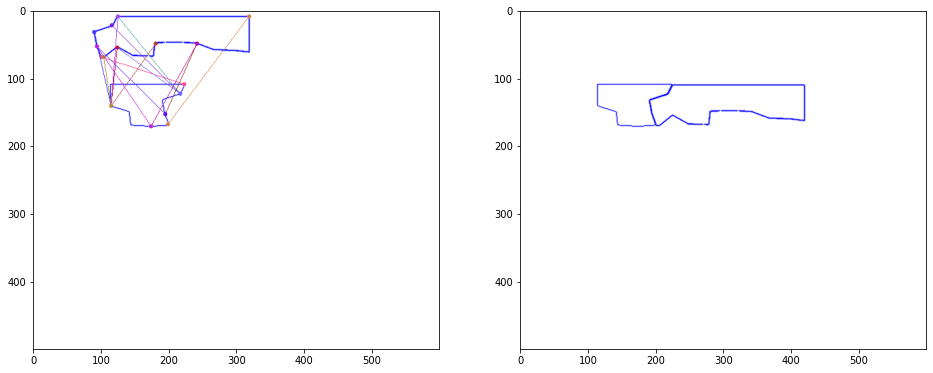

1 3
2 3
match found!


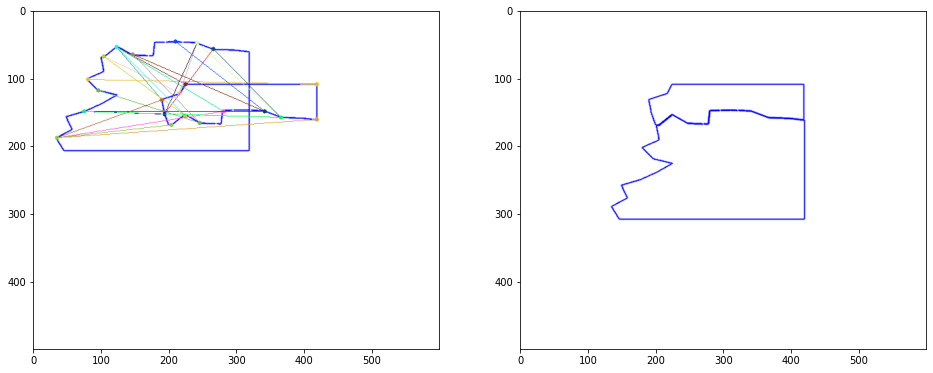

In [174]:
img0 = '/content/puzzle_parts/pol0.png'
img1 = '/content/puzzle_parts/pol1.png' 
img2 = '/content/puzzle_parts/pol2.png' 
img3 = '/content/puzzle_parts/pol3.png'

images = [img0, img1, img2, img3]

# fig = plt.figure(figsize=(16, 9))
# columns = 2
# rows = 2
# for i in range(1, columns*rows +1):
#     img = images[i-1]
#     fig.add_subplot(rows, columns, i)
#     # plt.axis('off')
#     plt.imshow(img)
# plt.show()


# partsMatch = matchAllParts(images)
for i in range (len(images)):
  for j in range (len(images)):
    if (i!=j and i < j):
      print (i, j)
      partsMatch = matchParts(images[i],images[j])